# 🤖 Clasificación de Gestos EMG con Modelos Avanzados

¡Bienvenido! Este notebook es una guía para construir, entrenar y evaluar diversas arquitecturas de redes neuronales para la clasificación de gestos a partir de señales de electromiografía (EMG).

### ✨ Objetivo
El propósito de este notebook es "democratizar" el acceso a los modelos desarrollados, permitiendo que cualquier persona con los datos pre-procesados pueda:
1.  **Entender** las distintas arquitecturas de modelos.
2.  **Construir** los modelos desde cero.
3.  **Entrenar** un modelo de su elección.
4.  **Evaluar** el rendimiento del modelo entrenado.

### 💾 Prerrequisitos
Este notebook asume que ya has ejecutado el script de pre-procesado inicial y que tienes una carpeta llamada `saved_datasets` en el mismo directorio. Esta carpeta debe contener:
- Los `tf.data.Dataset` guardados (`train_ds_h`, `test_ds_raw`, etc.).
- El archivo de metadatos `meta.json`.

---

In [14]:
import os
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 0. Configuración Global y Rutas ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Directorios
SAVE_ROOT = Path("saved_datasets")
MODELS_DIR = Path("models_entrenados")
MODELS_DIR.mkdir(exist_ok=True)

print("✅ Entorno configurado.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

✅ Entorno configurado.
TensorFlow Version: 2.10.0
Num GPUs Available: 1


## 💾 Paso 1: Carga de Datos Pre-procesados

Primero, cargamos todos los conjuntos de datos y metadatos desde la carpeta `saved_datasets`. Esto nos da acceso instantáneo a los datos de entrenamiento, validación y prueba, tanto en su formato "crudo" (para modelos CNN/LSTM puros) como "híbrido" (datos crudos + características manuales).

In [15]:
if not SAVE_ROOT.exists():
    raise FileNotFoundError(f"La carpeta '{SAVE_ROOT}' no existe. "
                          "Asegúrate de ejecutar el script de pre-procesado primero.")

# --- Cargar Metadatos ---
with open(SAVE_ROOT / "meta.json") as fp:
    meta = json.load(fp)
RAW_SHAPE = tuple(meta["RAW_SHAPE"])
feat_dim = meta["feat_dim"]
NUM_CLASSES = meta["num_classes"]

# --- Cargar Datasets de TensorFlow ---
try:
    print("Cargando datasets de TensorFlow...")
    ds_map = {
        'hybrid': {
            'train': tf.data.Dataset.load(str(SAVE_ROOT / "train_ds_h")),
            'val': tf.data.Dataset.load(str(SAVE_ROOT / "val_ds_h")),
            'test': tf.data.Dataset.load(str(SAVE_ROOT / "test_ds_h"))
        },
        'raw': {
            'train': tf.data.Dataset.load(str(SAVE_ROOT / "train_ds_raw")),
            'val': tf.data.Dataset.load(str(SAVE_ROOT / "val_ds_raw")),
            'test': tf.data.Dataset.load(str(SAVE_ROOT / "test_ds_raw"))
        }
    }
    print("✅ Datasets cargados correctamente.")
    print(f"Dimensiones de entrada (raw): (Tiempo, {RAW_SHAPE[0]}, {RAW_SHAPE[1]}, {RAW_SHAPE[2]})")
    print(f"Dimensiones de entrada (features): (Tiempo, {feat_dim})")
    print(f"Número de clases: {NUM_CLASSES}")

except Exception as e:
    print(f"\n❌ Error al cargar los datasets. ¿Están completos en la carpeta '{SAVE_ROOT}'?")
    print(f"   Error original: {e}")

Cargando datasets de TensorFlow...
✅ Datasets cargados correctamente.
Dimensiones de entrada (raw): (Tiempo, 20, 10, 1)
Dimensiones de entrada (features): (Tiempo, 100)
Número de clases: 12


## 🧠 Paso 2: Definición de las Arquitecturas

Aquí se encuentran las funciones para construir cada uno de los modelos. Cada función define la arquitectura de la red, la compila con un optimizador y una función de pérdida, y la devuelve lista para ser entrenada.

- **`HyT-Net`**: Modelo híbrido que combina una CNN para extraer rasgos de las ventanas de EMG con un *Transformer Encoder* para capturar las dependencias temporales.
- **`DualStream-Original`**: Implementación fiel al paper, con dos flujos (datos crudos y características) que son procesados por separado antes de fusionarse.
- **`DualStream-Lite`**: Versión más ligera y adaptada del modelo DualStream.
- **`EMGHandNet-Original`**: Implementación fiel al paper, usando Conv1D y Bi-LSTM.
- **`EMGHandNet-2D`**: Adaptación que usa Conv2D, tratando las ventanas de EMG como imágenes.
- **`CRNN-Attn`**: Una Red Neuronal Convolucional-Recurrente con un mecanismo de Atención.

In [16]:
from tensorflow.keras import layers, models, regularizers

# ------------------------------------------------------------------------- #
# 🧠 DEFINICIÓN DE ARQUITECTURAS DE MODELOS
# ------------------------------------------------------------------------- #

# Capa de Atención personalizada, necesaria para CRNN-Attn
class Attention(layers.Layer):
    """Capa de Atención personalizada para modelos tipo CRNN."""
    def build(self, inp_shape):
        u = inp_shape[-1]
        self.W = self.add_weight("W", (u, u), initializer="glorot_uniform")
        self.b = self.add_weight("b", (u,), initializer="zeros")
        self.u = self.add_weight("u", (u, 1), initializer="glorot_uniform")
    def call(self, x):
        v = tf.tanh(tf.tensordot(x, self.W, 1) + self.b)
        vu = tf.tensordot(v, self.u, 1)
        al = tf.nn.softmax(tf.squeeze(vu, -1), 1)
        return tf.reduce_sum(x * tf.expand_dims(al, -1), 1)

# Diccionario para registrar los constructores de modelos y sus requerimientos
model_builders = {}


# --- Modelo 1: HyT-Net (Híbrido CNN-Transformer) ---
def build_hyt_net(raw_shape, feat_dim, T, n_cls, heads=4, dim=128, dp=0.3):
    """Arquitectura Híbrida CNN-Transformer (HyT-Net) propuesta en esta tesis."""
    # Rama CNN para extraer características de cada ventana EMG
    seg_in = layers.Input(raw_shape, name="seg_input")
    x_cnn = layers.Conv2D(64, (5,1), padding="same", activation="relu")(seg_in)
    x_cnn = layers.BatchNormalization()(x_cnn)
    x_cnn = layers.Conv2D(64, (3,1), padding="same", activation="relu")(x_cnn)
    x_cnn = layers.BatchNormalization()(x_cnn)
    seg_vec = layers.GlobalAveragePooling2D()(x_cnn)
    seg_cnn_model = models.Model(seg_in, seg_vec, name="segment_cnn")

    # Entradas principales del modelo
    in_raw = layers.Input((T, *raw_shape), name="raw")
    in_feat = layers.Input((T, feat_dim), name="feat")
    
    # Procesamiento temporal y fusión
    raw_seq = layers.TimeDistributed(seg_cnn_model)(in_raw)
    feat_seq = layers.TimeDistributed(layers.Dense(64, activation="relu"))(in_feat)
    fusion = layers.Concatenate(axis=-1)([raw_seq, feat_seq])
    projection = layers.Dense(dim, activation="linear")(fusion)

    # Bloques Transformer Encoder para capturar dependencias temporales
    def transformer_encoder_block(seq_input):
        x = layers.LayerNormalization(epsilon=1e-6)(seq_input)
        x = layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dp)(x, x)
        res = x + seq_input
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Dense(dim * 4, activation="relu")(x)
        x = layers.Dense(dim)(x)
        return x + res
    
    z = transformer_encoder_block(projection)
    z = transformer_encoder_block(z)

    # Clasificador final
    z = layers.GlobalAveragePooling1D()(z)
    z = layers.Dropout(dp)(z)
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(dp)(z)
    out = layers.Dense(n_cls, activation="softmax", name="output")(z)
    
    model = models.Model(inputs=[in_raw, in_feat], outputs=out, name="HyT-Net")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model_builders['HyT-Net'] = (build_hyt_net, True) # True indica que usa features manuales


# --- Modelo 2: DualStream-Lite ---
def build_dualstream_lite(raw_shape, feat_dim, T, n_cls, rf=64, ff=64, lstm=128, dp=0.3):
    """Versión adaptada y ligera del concepto DualStream."""
    in_r = layers.Input((T, *raw_shape), name="raw")
    in_f = layers.Input((T, feat_dim), name="feat")
    
    # Flujo de datos crudos
    r = layers.TimeDistributed(layers.Reshape((raw_shape[0], raw_shape[1])))(in_r)
    r = layers.TimeDistributed(layers.Conv1D(rf, 3, padding="same", activation="relu"))(r)
    r = layers.TimeDistributed(layers.GlobalAveragePooling1D())(r)
    
    # Flujo de características manuales
    f = layers.TimeDistributed(layers.Dense(ff, activation="relu"))(in_f)
    
    # Fusión y bloque recurrente
    x = layers.Concatenate()([r, f])
    x = layers.TimeDistributed(layers.Dropout(dp))(x)
    x = layers.Bidirectional(layers.LSTM(lstm, return_sequences=False, dropout=dp))(x)
    out = layers.Dense(n_cls, activation="softmax")(x)
    
    model = models.Model([in_r, in_f], out, name="DualStream-Lite")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model_builders['DualStream-Lite'] = (build_dualstream_lite, True)


# --- Modelo 3: EMGHandNet-2D ---
def build_emghandnet_2d(raw_shape, T, n_cls, filters=(64,128), lstm=128, dp=.3):
    """Versión de EMGHandNet que utiliza Conv2D, tratando las ventanas como imágenes."""
    inp = layers.Input((T, *raw_shape), name="raw")
    x = inp
    for f in filters:
        x = layers.TimeDistributed(layers.Conv2D(f, (3, 3), padding="same", activation="relu"))(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPool2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
    x = layers.TimeDistributed(layers.Dropout(dp))(x)
    x = layers.Bidirectional(layers.LSTM(lstm, return_sequences=False, dropout=dp))(x)
    out = layers.Dense(n_cls, activation="softmax")(x)
    
    model = models.Model(inp, out, name="EMGHandNet-2D")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model_builders['EMGHandNet-2D'] = (build_emghandnet_2d, False) # False indica que NO usa features


# --- Modelo 4: DualStream-Original ---
def build_dualstream_original(raw_shape, feat_dim, T, n_cls, lstm_units=200, conv_filters=256, dp=0.3):
    """Implementación fiel del modelo Dual Stream LSTM Feature Fusion (Zhang et al., 2024)."""
    in_raw = layers.Input(shape=(T, *raw_shape), name="raw")
    in_feat = layers.Input(shape=(T, feat_dim), name="feat")
    # Flujo de Datos Crudos
    r = layers.TimeDistributed(layers.Reshape((raw_shape[0], raw_shape[1])))(in_raw)
    r = layers.TimeDistributed(layers.Conv1D(conv_filters, 3, padding="same", activation="relu"))(r)
    r = layers.TimeDistributed(layers.LSTM(lstm_units, return_sequences=True, dropout=dp))(r)
    r = layers.TimeDistributed(layers.Conv1D(conv_filters, 3, padding="same", activation="relu"))(r)
    r = layers.TimeDistributed(layers.GlobalAveragePooling1D())(r)
    # Flujo de Características
    f = layers.Reshape((T, feat_dim, 1))(in_feat)
    f = layers.TimeDistributed(layers.Conv1D(conv_filters, 3, padding="same", activation="relu"))(f)
    f = layers.TimeDistributed(layers.Conv1D(conv_filters, 3, padding="same", activation="relu"))(f)
    f = layers.TimeDistributed(layers.GlobalAveragePooling1D())(f)
    # Fusión y Bloque Temporal
    x = layers.Concatenate()([r, f])
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, dropout=dp))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False, dropout=dp))(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dp)(x)
    out = layers.Dense(n_cls, activation="softmax", name="output")(x)
    
    model = models.Model(inputs=[in_raw, in_feat], outputs=out, name="DualStream-Original")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model_builders['DualStream-Original'] = (build_dualstream_original, True)


# --- Modelo 5: EMGHandNet-Original ---
def build_emghandnet_original(raw_shape, T, n_cls, filters=(64, 64, 64, 64), lstm_units=200, dp=0.3):
    """Implementación fiel del modelo EMGHandNet (Karnam et al., 2022) usando Conv1D."""
    inp = layers.Input(shape=(T, *raw_shape), name="raw")
    x = layers.TimeDistributed(layers.Reshape((raw_shape[0], raw_shape[1])))(inp)
    for i, f in enumerate(filters):
        x = layers.TimeDistributed(layers.Conv1D(f, 3, padding="same", activation="relu"))(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPool1D(2))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, dropout=dp))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False, dropout=dp))(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dp)(x)
    out = layers.Dense(n_cls, activation="softmax", name="output")(x)
    
    model = models.Model(inputs=inp, outputs=out, name="EMGHandNet-Original")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model_builders['EMGHandNet-Original'] = (build_emghandnet_original, False)


# --- Modelo 6: CRNN-Attn (Red Convolucional-Recurrente con Atención) ---
def build_crnn_attn(raw_shape, feat_dim, T, n_cls, gru=128, dp=.3):
    """Modelo que usa una CNN ligera (MobileNet-style), una GRU y un mecanismo de Atención."""
    def mobile_cnn_block(inp_shape):
        inp = layers.Input(inp_shape)
        x = layers.SeparableConv2D(int(32 * 0.75), 3, padding="same", activation="relu")(inp)
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(int(64 * 0.75), 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.2)(x)
        return models.Model(inp, x, name="mobile_cnn")

    cnn = mobile_cnn_block(raw_shape)
    in_r  = layers.Input((T,*raw_shape), name="raw")
    in_f  = layers.Input((T,feat_dim),  name="feat")
    r = layers.TimeDistributed(cnn)(in_r)
    f = layers.TimeDistributed(layers.Dense(96, activation="relu"))(in_f)
    mrg = layers.Concatenate()([r,f])
    x = layers.Bidirectional(layers.GRU(gru, return_sequences=True, dropout=dp, recurrent_dropout=dp*0.5))(mrg)
    x = Attention()(x)
    x = layers.Dropout(dp)(x)
    out = layers.Dense(n_cls, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)
    
    model = models.Model([in_r,in_f], out, name="CRNN-Attn")
    model.compile(optimizer=tf.keras.optimizers.Adam(2e-3),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.1),
                  metrics=["accuracy"])
    return model
model_builders['CRNN-Attn'] = (build_crnn_attn, True)


print(f"✅ Definidas y registradas {len(model_builders)} arquitecturas de modelos.")

✅ Definidas y registradas 6 arquitecturas de modelos.


## 🚀 Paso 3: Entrenar un Modelo

¡Ahora la parte divertida! En la siguiente celda, puedes elegir qué modelo quieres entrenar simplemente cambiando el valor de la variable `MODEL_TO_TRAIN`.

El script se encargará de:
1.  Seleccionar la función constructora correcta.
2.  Elegir el conjunto de datos apropiado (`hybrid` o `raw`).
3.  Construir e instanciar el modelo.
4.  Mostrar un resumen de su arquitectura.
5.  Entrenarlo usando los datos de `train` y `validation`.

In [17]:
# --- Elige el modelo que quieres entrenar ---
MODEL_TO_TRAIN = 'HyT-Net'  # Opciones: 'HyT-Net', 'DualStream-Lite', 'EMGHandNet-2D', etc.
EPOCHS = 1 # Usamos menos épocas para una demostración rápida

# --- Selección automática del constructor y los datos ---
if MODEL_TO_TRAIN not in model_builders:
    raise ValueError(f"Modelo '{MODEL_TO_TRAIN}' no reconocido. Opciones: {list(model_builders.keys())}")

builder_fn, uses_features = model_builders[MODEL_TO_TRAIN]
dataset_type = 'hybrid' if uses_features else 'raw'

print(f"🔹 Modelo seleccionado: {MODEL_TO_TRAIN}")
print(f"🔹 Tipo de datos: {dataset_type}")

# --- Construcción del modelo ---
tf.keras.backend.clear_session()
if uses_features:
    model = builder_fn(RAW_SHAPE, feat_dim, 5, NUM_CLASSES) # T_SUBWIN=5
else:
    model = builder_fn(RAW_SHAPE, 5, NUM_CLASSES) # T_SUBWIN=5

print("\nArquitectura del Modelo:")
model.summary()

# --- Callbacks para el entrenamiento ---
checkpoint_path = MODELS_DIR / f"{model.name}_DEMO.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# --- Entrenamiento ---
print(f"\nIniciando entrenamiento por {EPOCHS} épocas...")
history = model.fit(
    ds_map[dataset_type]['train'],
    validation_data=ds_map[dataset_type]['val'],
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("✅ Entrenamiento finalizado.")

🔹 Modelo seleccionado: HyT-Net
🔹 Tipo de datos: hybrid

Arquitectura del Modelo:
Model: "HyT-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 raw (InputLayer)               [(None, 5, 20, 10,   0           []                               
                                1)]                                                               
                                                                                                  
 feat (InputLayer)              [(None, 5, 100)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 64)       13248       ['raw[0][0]']                    
 ted)                                                                                             
           

## 📈 Paso 4: Evaluación del Rendimiento

Una vez entrenado el modelo, el siguiente paso es evaluar su rendimiento en el conjunto de prueba (`test`), que es un conjunto de datos que el modelo nunca ha visto. Esto nos da una medida objetiva de su capacidad de generalización.

Cargando el mejor checkpoint guardado en: models_entrenados\HyT-Net_DEMO.keras

Evaluando rendimiento en el conjunto de Test...
  -> Pérdida (Loss) en Test: 1.0088
  -> Precisión (Accuracy) en Test: 65.68%

Generando reporte detallado...
259/259 [==============================] - 2s 8ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

     Gesto 1       0.85      0.62      0.72      2876
     Gesto 2       0.70      0.85      0.77      2814
     Gesto 3       0.57      0.69      0.62      3157
     Gesto 4       0.79      0.64      0.71      2618
     Gesto 5       0.67      0.77      0.72      2618
     Gesto 6       0.78      0.54      0.64      2751
     Gesto 7       0.60      0.73      0.66      2784
     Gesto 8       0.64      0.67      0.65      2933
     Gesto 9       0.48      0.58      0.53      2698
    Gesto 10       0.66      0.63      0.64      2607
    Gesto 11       0.65      0.58      0.61      2470
    Gesto 12       0.69      0.

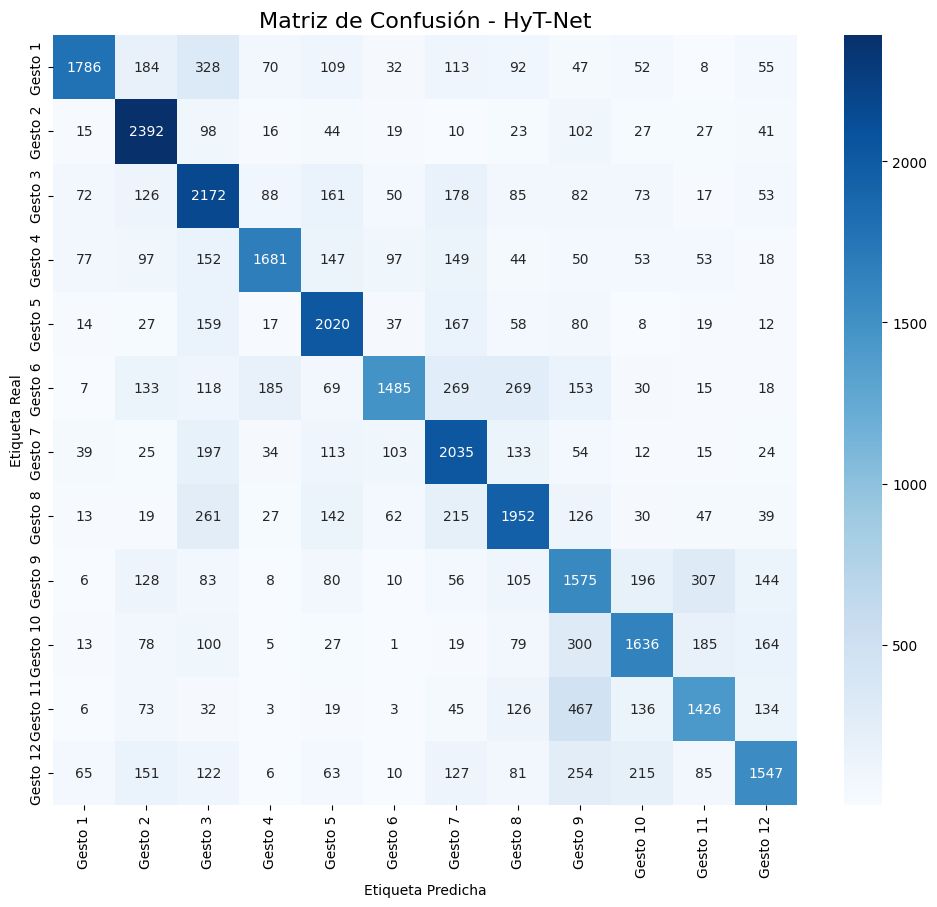

In [18]:
# --- Cargar el mejor modelo guardado durante el entrenamiento ---
print(f"Cargando el mejor checkpoint guardado en: {checkpoint_path}")
trained_model = tf.keras.models.load_model(checkpoint_path, custom_objects={'Attention': Attention})

# --- Evaluar en el conjunto de Test ---
test_dataset = ds_map[dataset_type]['test']
print("\nEvaluando rendimiento en el conjunto de Test...")
loss, accuracy = trained_model.evaluate(test_dataset, verbose=0)
print(f"  -> Pérdida (Loss) en Test: {loss:.4f}")
print(f"  -> Precisión (Accuracy) en Test: {accuracy:.2%}")

# --- Reporte de Clasificación detallado y Matriz de Confusión ---
print("\nGenerando reporte detallado...")
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

predictions = trained_model.predict(test_dataset)
y_pred_classes = np.argmax(predictions, axis=1)

CLASS_NAMES_REPORT = [f'Gesto {i+1}' for i in range(NUM_CLASSES)]
print("\nReporte de Clasificación:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES_REPORT))

# Matriz de Confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES_REPORT, yticklabels=CLASS_NAMES_REPORT)
plt.title(f'Matriz de Confusión - {model.name}', fontsize=16)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()